## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn

In [2]:
df = pd.read_csv("train.csv")

### Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [4]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
# Investigate the 3 rows that have the missing values
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [6]:
# Drop the missing values from the dataset
df.dropna(subset=['question1', 'question2'], inplace=True)

In [7]:
print('Not Duplicate Questions:', df[df.is_duplicate == 0].count()[0], '\nDuplicate Questions:', df[df.is_duplicate == 1].count()[0])
print('percent of duplicates', round((df[df.is_duplicate == 1].count()[0]/df.count()[0]),2))

Not Duplicate Questions: 255024 
Duplicate Questions: 149263
percent of duplicates 0.37


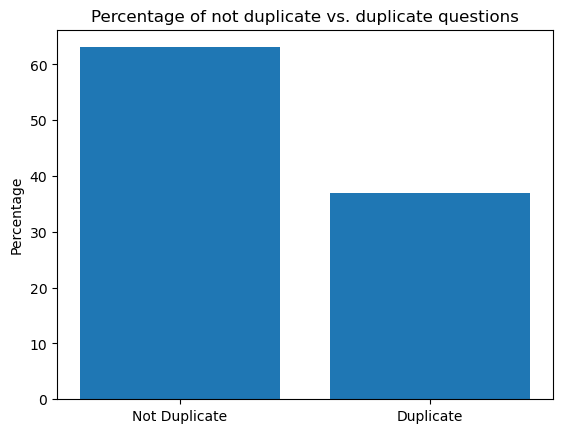

In [8]:
# Plot as a bar chart to see the percentage of duplicate and not duplicate labels
labels = ['Not Duplicate', 'Duplicate']

percentages = df['is_duplicate'].value_counts() / len(df) * 100

plt.bar(labels, percentages)
plt.title('Percentage of not duplicate vs. duplicate questions')
plt.ylabel('Percentage')
plt.show()

The dataset contains 255,024 unique questions and 149,263 questions that are duplicates. This information is crucial in understanding the dataset and approaching the model to identify duplicate questions. However, there is a noticeable imbalance between the number of non-duplicate and duplicate questions. This may affect the model's performance, making it biased towards classifying questions as non-duplicates. To address this issue, undersampling is employed to balance the dataset and improve the model's performance.

In [9]:
# Select randomly a subset of non-duplicate questions to match the number of duplicate questions
duplicates = df[df['is_duplicate'] == 1] # Separate the duplicate and non-duplicate questions
non_duplicates = df[df['is_duplicate'] == 0]
num_duplicates = len(duplicates) # Get the number of duplicate questions
non_duplicates_sampled = non_duplicates.sample(num_duplicates) # Select a subset of non-duplicate questions

# Combine the sampled non-duplicate questions with the original duplicate questions
balanced_df = pd.concat([duplicates, non_duplicates_sampled], axis=0) 

# Shuffle the dataset to ensure that the duplicate and non-duplicate questions are mixed
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
balanced_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,316351,441386,441387,What is the best business online?,What are the best businesses online?,1
1,131099,85303,111285,What are the best technology?,What are the best technologies?,1
2,273807,392331,392332,"What fields or subfields you know of, if any, ...",Is being constantly professional overrated?,0
3,167,335,336,Which is correct - 'Looking forward to speak w...,"Which is correct: ""speak with"" or ""speak to""?",0
4,29186,54029,54030,What brands does Tom Ford wear on himself?,My son wants to wear my wedding dress to see w...,0


In [10]:
# Now, let's check if our dataset is more balanced
balanced_df['is_duplicate'].value_counts()

1    149263
0    149263
Name: is_duplicate, dtype: int64

Once we have splitted our dataset, we will only utilize the training set for cleaning, analyzing, and feature engineering, while the testing set will be kept separate and solely used to evaluate the performance of our model. 

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

### Punctuation

In [11]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
# Define a function to remove punctuation in our "question1" and "question2" columns
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

balanced_df = balanced_df.assign( # Assigning the new 2 columns in the dataframe
    question1_cleaned=balanced_df["question1"].apply(remove_punct),
    question2_cleaned=balanced_df["question2"].apply(remove_punct)
)

balanced_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned
0,316351,441386,441387,What is the best business online?,What are the best businesses online?,1,What is the best business online,What are the best businesses online
1,131099,85303,111285,What are the best technology?,What are the best technologies?,1,What are the best technology,What are the best technologies


In [13]:
# Drop the columns that are not going to be used anymore
balanced_df = balanced_df.drop(['question1', 'question2','qid1','qid2'], axis=1)
balanced_df.head(2)

,id,is_duplicate,question1_cleaned,question2_cleaned
0,316351,1,What is the best business online,What are the best businesses online
1,131099,1,What are the best technology,What are the best technologies


### Tokenization and applying lower case

In [14]:
# Import regular expression library
import re

In [15]:
# Define a function to split our sentences into a list of words
def tokenize(text):
    tokens = text.split()
    return tokens

balanced_df['question_1_tokenized'] = balanced_df['question1_cleaned'].apply(lambda x: tokenize(x.lower()))
balanced_df['question_2_tokenized'] = balanced_df['question2_cleaned'].apply(lambda x: tokenize(x.lower()))
balanced_df.head(2)

,id,is_duplicate,question1_cleaned,question2_cleaned,question_1_tokenized,question_2_tokenized
0,316351,1,What is the best business online,What are the best businesses online,"[what, is, the, best, business, online]","[what, are, the, best, businesses, online]"
1,131099,1,What are the best technology,What are the best technologies,"[what, are, the, best, technology]","[what, are, the, best, technologies]"


In [16]:
# Drop the previous columns
balanced_df = balanced_df.drop(['question1_cleaned', 'question2_cleaned'], axis=1)
balanced_df.head(2)

,id,is_duplicate,question_1_tokenized,question_2_tokenized
0,316351,1,"[what, is, the, best, business, online]","[what, are, the, best, businesses, online]"
1,131099,1,"[what, are, the, best, technology]","[what, are, the, best, technologies]"


### Stop Words

In [17]:
# Import the NLTK package
import nltk
from nltk.corpus import stopwords

# View the stopwords
ENGstopwords = stopwords.words('english')
ENGstopwords[0:5]

['i', 'me', 'my', 'myself', 'we']

In [18]:
# Define a function to remove stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

balanced_df['question1_non_stop'] = balanced_df['question_1_tokenized'].apply(lambda x: remove_stopwords(x))
balanced_df['question2_non_stop'] = balanced_df['question_2_tokenized'].apply(lambda x: remove_stopwords(x))
balanced_df.head(2)

,id,is_duplicate,question_1_tokenized,question_2_tokenized,question1_non_stop,question2_non_stop
0,316351,1,"[what, is, the, best, business, online]","[what, are, the, best, businesses, online]","[best, business, online]","[best, businesses, online]"
1,131099,1,"[what, are, the, best, technology]","[what, are, the, best, technologies]","[best, technology]","[best, technologies]"


In [19]:
# Drop the previous columns
balanced_df = balanced_df.drop(['question_1_tokenized', 'question_2_tokenized'], axis=1)
balanced_df.head(2)

,id,is_duplicate,question1_non_stop,question2_non_stop
0,316351,1,"[best, business, online]","[best, businesses, online]"
1,131099,1,"[best, technology]","[best, technologies]"


### Stemming

In [20]:
from nltk.stem import PorterStemmer

In [21]:
# Create a stemmer object
ps = PorterStemmer() # It will remove pre-defined stems

# Define a function to stem the text
def stemmed_text(words):
    stemmed_words = [] # It initializes a new variable list
    for word in words:
        stemmed_words.append(ps.stem(word))
    return stemmed_words

In [22]:
# Call up the function that applies "stemmed_text" to our columns in the data frame
balanced_df['question1_stem'] = balanced_df['question1_non_stop'].apply(lambda x: stemmed_text(x))
balanced_df['question2_stem'] = balanced_df['question2_non_stop'].apply(lambda x: stemmed_text(x))
balanced_df.head(2)

,id,is_duplicate,question1_non_stop,question2_non_stop,question1_stem,question2_stem
0,316351,1,"[best, business, online]","[best, businesses, online]","[best, busi, onlin]","[best, busi, onlin]"
1,131099,1,"[best, technology]","[best, technologies]","[best, technolog]","[best, technolog]"


### Lemetization

Prior to discarding the preceding columns, we will conduct a comparison of the alterations achieved through stemming with those produced by lemmatization.

In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [24]:
# create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize each list of words
def lemmatize_words(words_list):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words_list]
    return lemmatized_words

In [27]:
# Call up the function that applies lemmatization to our columns in the data frame
balanced_df['question1_lemm'] = balanced_df['question1_stem'].apply(lambda x: lemmatize_words(x))
balanced_df['question2_lemm'] = balanced_df['question2_stem'].apply(lambda x: lemmatize_words(x))
balanced_df.head(2)

,id,is_duplicate,question1_non_stop,question2_non_stop,question1_stem,question2_stem,question1_lemm,question2_lemm
0,316351,1,"[best, business, online]","[best, businesses, online]","[best, busi, onlin]","[best, busi, onlin]","[best, busi, onlin]","[best, busi, onlin]"
1,131099,1,"[best, technology]","[best, technologies]","[best, technolog]","[best, technolog]","[best, technolog]","[best, technolog]"


In [28]:
# Drop previous columns and staying with the lemmatization technique
balanced_df = balanced_df.drop(['question1_non_stop', 'question2_non_stop', 'question1_stem', 'question2_stem'], axis=1)
balanced_df.head(2)

,id,is_duplicate,question1_lemm,question2_lemm
0,316351,1,"[best, busi, onlin]","[best, busi, onlin]"
1,131099,1,"[best, technolog]","[best, technolog]"


### Defining a single function for preprocessing for future data

In [63]:
#remove punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text
    
def preprocess_text(text):
    #remove punctuation
    text = remove_punct(text)
    
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text) 
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a string
    text = ' '.join(words)
    
    return text

In [32]:
balanced_df.to_csv('clean_df.csv', index=False)

In [34]:
balanced_df

,id,is_duplicate,question1_lemm,question2_lemm
0,316351,1,"[best, busi, onlin]","[best, busi, onlin]"
1,131099,1,"[best, technolog]","[best, technolog]"
2,273807,0,"[field, subfield, know, mit, harvard, highli, ...","[constantli, profession, overr]"
3,167,0,"[correct, look, forward, speak, look, forward,...","[correct, speak, speak]"
4,29186,0,"[brand, tom, ford, wear]","[son, want, wear, wed, dress, see, feel, like,..."
...,...,...,...,...
298521,70366,1,"[l, find, locat, person, use, mobil, number]","[track, person, mobil, number]"
298522,76495,1,"[secur, code, master, card]","[secur, code, visa, card, use]"
298523,304411,0,"[avoid, attract, phone]","[best, way, avoid, phone]"
298524,115240,0,"[iphon, 5, receiv, io, 10, upgrad]","[io, 10, releas, iphon, 5]"


## Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [36]:
# Split the dataset into X and y variables
X = balanced_df[['question1_lemm', 'question2_lemm']]
y = balanced_df['is_duplicate']

###  tf-idf

In [37]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

import string

In [38]:
# TFIDF Vectorizer
vectorizer = TfidfVectorizer()

In [39]:
X['len_question1'] = X['question1_lemm'].apply(lambda x: len(x))
X['len_question2'] = X['question2_lemm'].apply(lambda x: len(x))

C:\Users\farha\AppData\Local\Temp\ipykernel_1448\3077633554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['len_question1'] = X['question1_lemm'].apply(lambda x: len(x))


In [40]:
X['question1_lemm'] = X['question1_lemm'].apply(lambda x: ' '.join([str(elem) for elem in x]))
X['question2_lemm'] = X['question2_lemm'].apply(lambda x: ' '.join([str(elem) for elem in x]))

In [41]:
X['word_diff'] = X.apply(lambda x: abs(x['len_question1']-x['len_question2']), axis=1)

In [42]:
X.head(2)

,question1_lemm,question2_lemm,len_question1,len_question2,word_diff
0,best busi onlin,best busi onlin,3,3,0
1,best technolog,best technolog,2,2,0


In [44]:
# convert question1_lemm,question2_lemm from text to features
X_vectorized= vectorizer.fit_transform(X['question1_lemm'] + X['question2_lemm'])

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=50)

In [50]:
X_vectorized

<298526x220828 sparse matrix of type '<class 'numpy.float64'>'
	with 2305451 stored elements in Compressed Sparse Row format>

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

#### Logistic Regression

In [51]:
from sklearn.metrics import classification_report

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

Accuracy: 0.7251867484004958


Text(113.9222222222222, 0.5, 'predicted label')

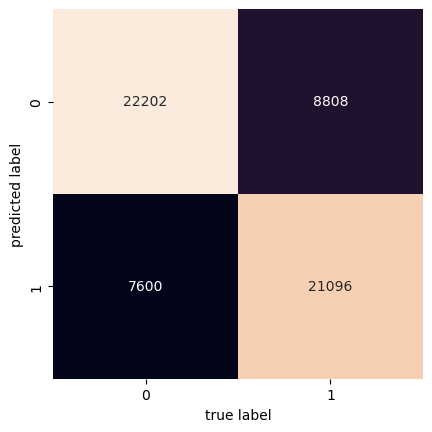

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# create a logistic regression model
model = LogisticRegression(max_iter=1000)

# fit the model to the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

#### XGBOOST

Accuracy: 0.6874853448564633


Text(113.9222222222222, 0.5, 'predicted label')

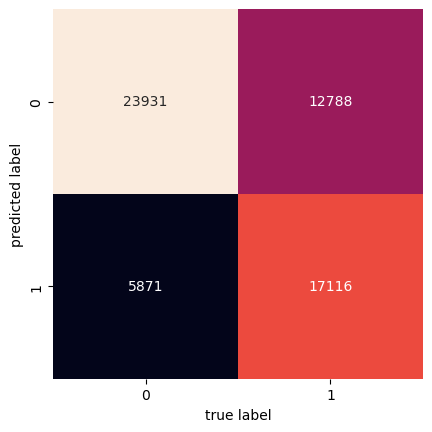

In [54]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# set XGBoost parameters
params = {'objective': 'binary:logistic', 'eval_metric': 'error', 'max_depth': 5}

# train XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# make predictions on test data
y_pred = xgb_model.predict(dtest)

# round predictions to the nearest integer
y_pred = [int(round(pred)) for pred in y_pred]

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

#### Naive Bayes

In [55]:
from sklearn.naive_bayes import GaussianNB

In [56]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes(X_train, X_test, y_train, y_test):
    # Create a Multinomial Naive Bayes classifier
    nb_classifier = MultinomialNB()
    
    # Train the classifier on the training data
    nb_classifier.fit(X_train, y_train)

    # Use the trained classifier to make predictions on the test data
    y_pred = nb_classifier.predict(X_test)

    # Compute and print the accuracy of the classifier
    accuracy = (y_pred == y_test).mean()
    print("Accuracy:", accuracy)
    
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

Accuracy: 0.7243828090979131


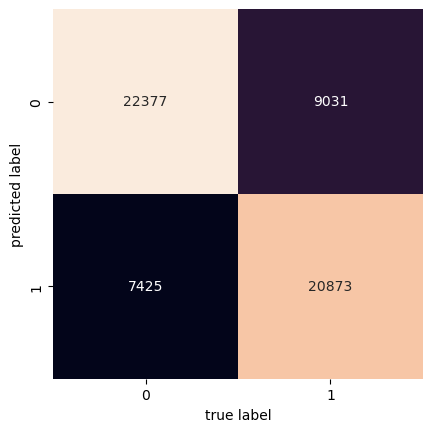

In [57]:
naive_bayes(X_train, X_test, y_train, y_test)

#### LSTMs

In [58]:
import tensorflow as tf


In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the IMDB dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

# Combine the training and testing data
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Set the maximum length to the length of the longest review
maxlen = max([len(x) for x in X])

# Preprocess the data
tokenizer = Tokenizer(num_words=10000)
X = tokenizer.sequences_to_matrix(X, mode='binary')
X = pad_sequences(X, maxlen=maxlen)

# Split the data back into training and testing sets
X_train = X[:len(X_train)]
X_test = X[len(X_train):]

# Create the model
model = Sequential()
model.add(Dense(512, input_shape=(maxlen,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
782/782 [==============================] - 19s 23ms/step - loss: 0.6446 - accuracy: 0.6066 - val_loss: 0.6534 - val_accuracy: 0.5992
Epoch 2/5
782/782 [==============================] - 20s 26ms/step - loss: 0.5578 - accuracy: 0.6900 - val_loss: 0.6837 - val_accuracy: 0.5912
Epoch 3/5
782/782 [==============================] - 21s 27ms/step - loss: 0.4968 - accuracy: 0.7278 - val_loss: 0.7248 - val_accuracy: 0.5917
Epoch 4/5
782/782 [==============================] - 20s 26ms/step - loss: 0.4212 - accuracy: 0.7678 - val_loss: 0.8803 - val_accuracy: 0.5898
Epoch 5/5
782/782 [==============================] - 22s 28ms/step - loss: 0.3472 - accuracy: 0.8096 - val_loss: 1.0799 - val_accuracy: 0.5913


In [60]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 1.0799 - accuracy: 0.5913
Test loss: 1.0799059867858887
Test accuracy: 0.5912799835205078


#### Random Forest

In [61]:
from keras import backend as K

# Define the function to extract the learned features from the model
get_features = K.function([model.layers[0].input], [model.layers[-2].output])

# Extract the learned features from the training and test sets
X_train_features = get_features([X_train])[0]
X_test_features = get_features([X_test])[0]

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest classifier on the extracted features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)

# Evaluate the random forest classifier on the test set
accuracy = rf.score(X_test_features, y_test)
print("Random Forest accuracy:", accuracy)

Random Forest accuracy: 0.58532
